# Dataset Testing & Experimentation

This notebook contains important statistics and models of the base simulated transient data. The insights gained from these tests help to identify patterns and trends in the data that can then be used to determine potential distributions

Dataset limitations:
- Current transient data is simulated, and lacks any form of noise that would be seen from the readings of an actual SPAD sensor
- Units for both time (IV) and photon intensity (DV) are arbitrary 

## Helpers:

In [1]:
# Constants
BOUNDS_PATH = "./dataset/gen_bounds.npy"
TRANS_PATH = "./dataset/gen_trans.npy"
SET_NUM = 0
BINS = 32

In [4]:
# Load from simulated data
bounds = np.load(BOUNDS_PATH)
transients = np.load(TRANS_PATH)

In [5]:
# Load Libraries (can be installed using `pip install -r min_requirements.txt`)
import numpy as np
import matplotlib.pyplot as plt
import statistics as stats

bds = bounds[SET_NUM, :].copy()
trs = transients[SET_NUM, :].copy()

# Get scene parameters
LASER_RES = len(trs)
DEFAULT_TR = stats.mode(stats.mode(data) for data in transients)

In [10]:
# View dataset
print(f'{bds} | {SET_NUM} | {bounds.shape}')
print(f'{trs} | {SET_NUM} | {transients.shape}')
print(f'{LASER_RES} | {DEFAULT_TR}')

[16254. 17583. 50000.] | 0 | (1, 3)
[5.e-06 5.e-06 5.e-06 ... 5.e-06 5.e-06 5.e-06] | 0 | (1, 100000)
100000 | 5e-06


In [11]:
# Helper functions
def convert_ew(b_set, t_set):
    """Generates x & y vals to fit EWH"""
    bins = len(b_set)+1
    step = LASER_RES / bins
    b_set = np.arange(0, LASER_RES+step, step)
    b_set = b_set[:-1] + (np.diff(b_set)/2)
    t_set = np.array([np.mean(arr) for arr in np.array_split(t_set, bins)])
    return b_set, t_set

def convert_ed(b_set, t_set):
    """Generates x & y vals to fit EDH"""
    bins = len(b_set)+1
    b_set = np.concatenate([[0], b_set, [LASER_RES]], axis=None)
    diffs = np.diff(b_set)
    b_set = b_set[:-1] + (diffs/2)
    t_set = np.array([DEFAULT_TR / (diffs[i] / diffs[0]) for i in range(len(b_set))])
    return b_set, t_set

## Graphs:

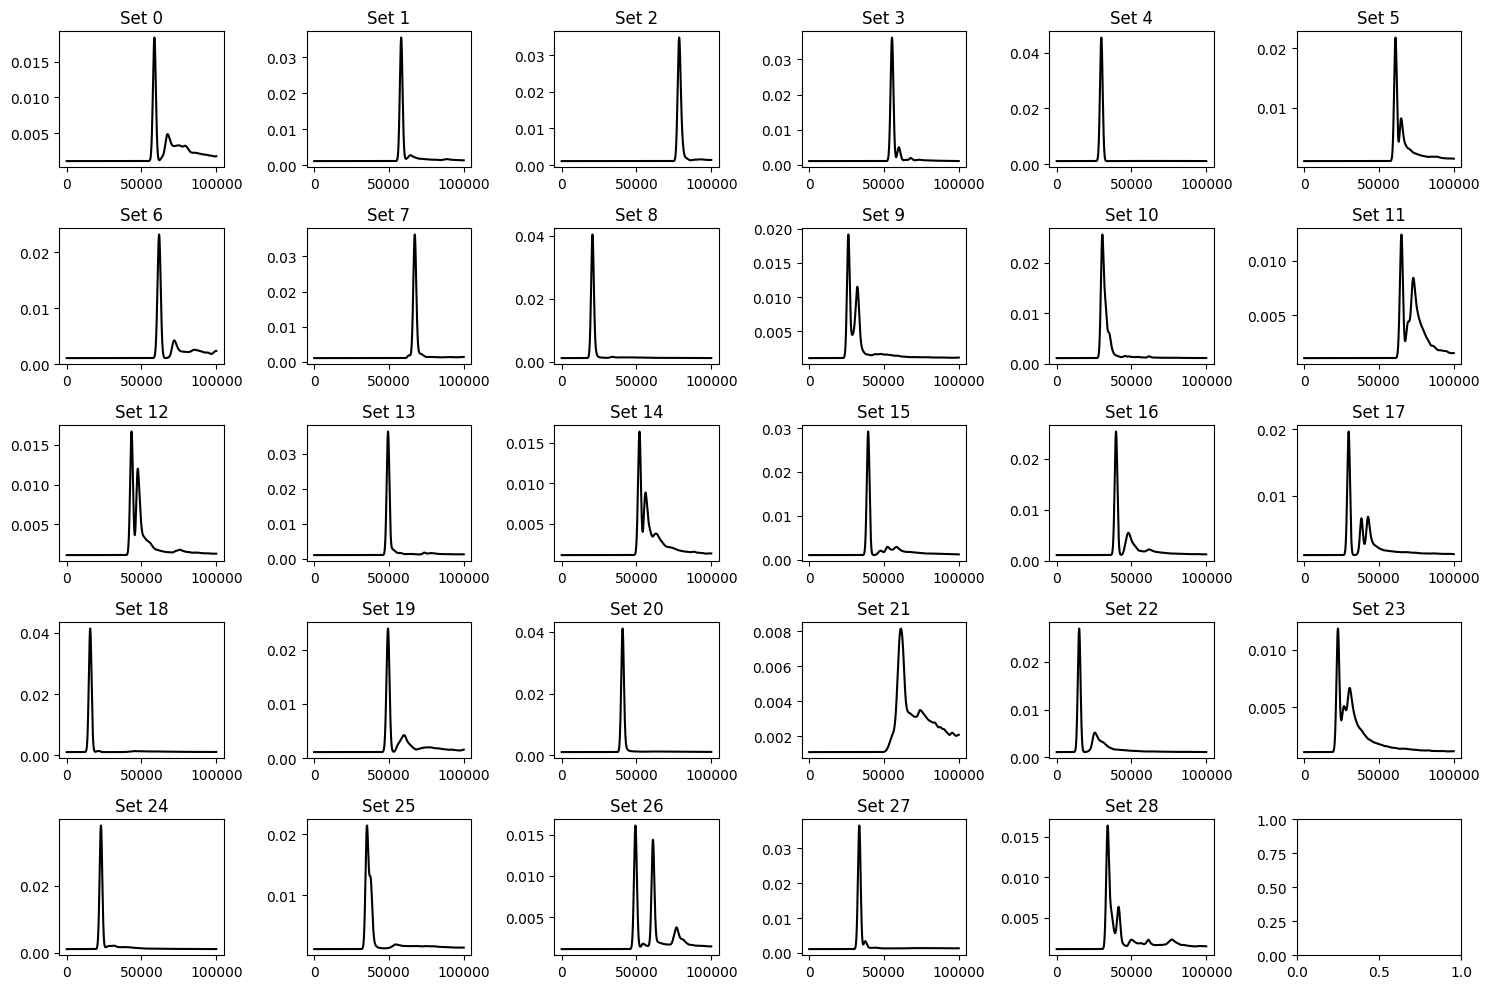

In [4]:
# Ground-truth plots of entire dataset
# TODO: replace magic #'s with constants
set_length = len(transients) if len(transients) == len(bounds) else 0
fig, axes = plt.subplots(5, 6, figsize=(15, 10))
for i in range(5):
    for j in range(6):
        set_num = (i*6)+j
        if set_num >= set_length:
            break
        axes[i,j].plot(transients[set_num, :], 'k')
        axes[i,j].title.set_text(f'Set {set_num}')
fig.tight_layout()

[ 64. 192. 320. 448. 576. 704. 832. 960.] [0.48832928 4.39448322 0.48828125 0.48828125 0.48828125 0.48828125
 0.48828125 0.48828125]
[ 78.5 161.5 169.5 176.5 218.  384.  640.  896. ] [0.0011     0.01918889 0.02467143 0.02467143 0.00227237 0.00067461
 0.00067461 0.00067461]


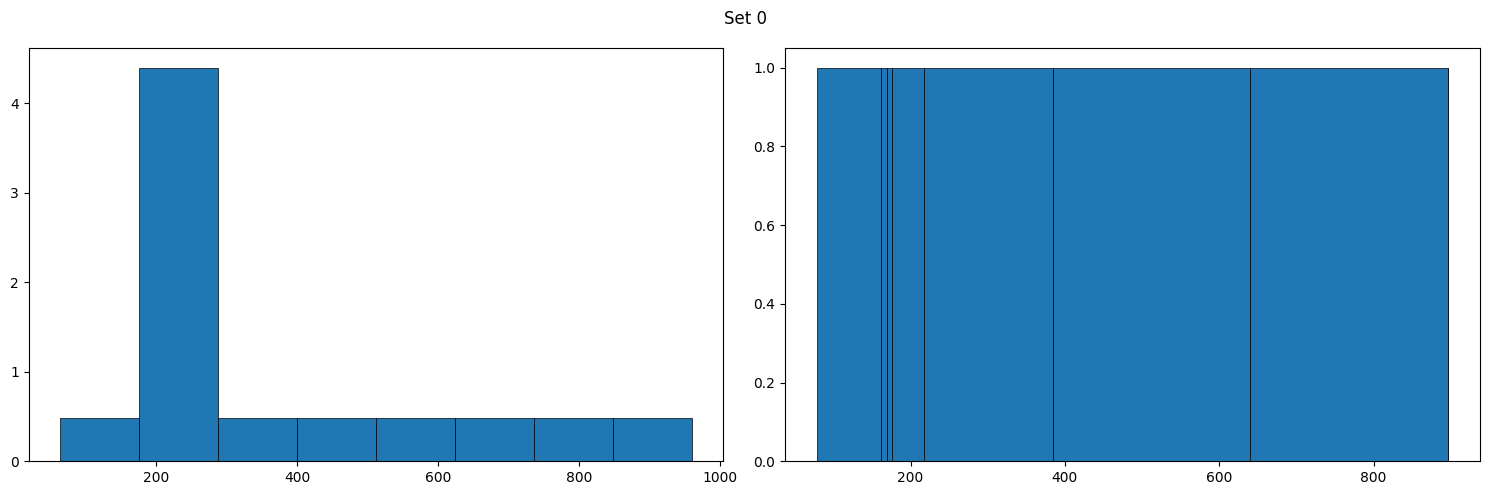

In [57]:
# Equi-width & equi-depth histograms for set chosen
ew_bds, ew_trs = convert_ew(bds.copy(), trs.copy())
ed_bds, ed_trs = convert_ed(bds.copy(), trs.copy())
print(ew_bds, ew_trs)
print(ed_bds, ed_trs)
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].hist(ew_bds, bins=8, weights=ew_trs, edgecolor='black', linewidth=0.5)
axes[1].hist(ed_bds, bins=np.append(ed_bds, np.max(ed_bds)+1), edgecolor='black', linewidth=0.5)
fig.suptitle(f'Set {SET_NUM}')
fig.tight_layout()

## Tests:

# Gaussian Process (GP) Regression

Implementation, graphing, and error testing of GP regression against the ground-truth transient arrival data. To put it simply, GP regression attempts to find a best-fit function (along with it's parameters) over a range of possible functions by using a kernel function to determine the relation between each point relative to it's neighbor in the training dataset. For testing purposes, this experiment makes use of *scikit-learn's* `GaussianProcessRegressor` class in order to more easily test the model's accuracy with the ground-truth data

## Implementation:

In [8]:
# GP model gen
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RationalQuadratic

def gaussian_model(b_set, t_set):
    lc = np.mean(np.diff(b_set))
    a = np.min(np.diff(b_set)) / np.max(np.diff(b_set))
    print(lc, a)
    kernel = RationalQuadratic(length_scale=lc, alpha=a, length_scale_bounds='fixed', alpha_bounds='fixed')
    return GaussianProcessRegressor(kernel=kernel).fit(b_set.reshape(-1, 1), t_set)

## Scaling test:

[ 2983.   8949.5 14916.5 20883.5 26850.5 32817.  38783.5 44750.5 50717.5
 55443.  57515.  58056.5 58450.5 58816.  59212.  59760.  61709.  64738.5
 66875.  68319.5 69961.5 71900.  73920.5 75932.5 77978.5 80074.  82464.5
 85243.5 88204.  91324.  94639.  48684.5] [ 4.88281250e-04  4.88199420e-04  4.88199420e-04  4.88199420e-04
  4.88199420e-04  4.88281250e-04  4.88199420e-04  4.88199420e-04
  4.88199420e-04  8.36132588e-04  4.41376657e-03  6.88672798e-03
  7.98105736e-03  7.95925120e-03  6.83822990e-03  4.34788946e-03
  9.02442979e-04  1.02899539e-03  2.02017055e-03  2.01319001e-03
  1.58578440e-03  1.42798330e-03  1.45581506e-03  1.43998316e-03
  1.40796807e-03  1.37280204e-03  1.09555695e-03  1.00485890e-03
  9.63959609e-04  9.05247339e-04  8.53776652e-04 -3.05607992e-05]
[ 32.   96.  140.5 155.  158.5 161.5 164.  165.5 167.  168.5 170.  172.
 173.5 175.  177.  179.  181.5 184.5 191.5 226.5 288.  352.  416.  480.
 544.  608.  672.  736.  800.  864.  928.  992. ] [0.00048828 0.00048828 0

/Users/csaldanha/src/python/SPAD_Regression_Research/venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:1897: RuntimeWarning: invalid value encountered in power
  K = base**-self.alpha
/Users/csaldanha/src/python/SPAD_Regression_Research/venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:1903: RuntimeWarning: invalid value encountered in power
  K = (1 + dists / (2 * self.alpha * self.length_scale**2)) ** -self.alpha


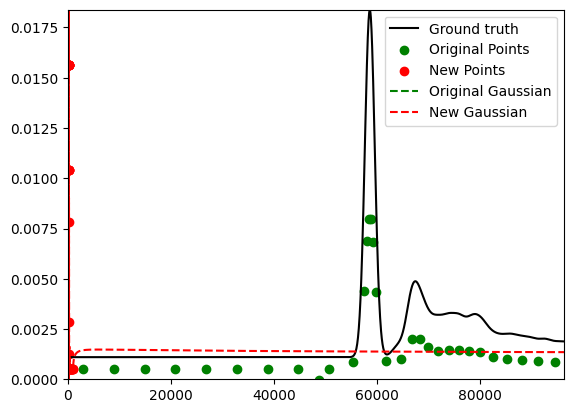

In [23]:
bounds = np.load(BOUNDS_PATH)
transients = np.load(TRANS_PATH)

bounds2, transients2 = gen_dataset(BINS)

x_test = np.arange(0, len(transients[SET_NUM, :])).reshape(-1, 1)

ed_bds, ed_trs = convert_ed(bounds[SET_NUM, :].copy(), transients[SET_NUM, :].copy())
print(ed_bds, ed_trs)
ed_bds2, ed_trs2 = convert_ed(bounds2[SET_NUM, :].copy(), transients2[SET_NUM, :].copy())
print(ed_bds2, ed_trs2)
ed_mod = gaussian_model(ed_bds, ed_trs)
ed_mod2 = gaussian_model(ed_bds2, ed_trs2)
ax = plt.gca()
ax.set_ylim([0, np.max(transients[SET_NUM, :])])
ax.set_xlim([0, np.max(bounds[SET_NUM, :])])
plt.plot(x_test, transients[SET_NUM, :], 'k', label='Ground truth')
plt.scatter(ed_bds, ed_trs, color='g', label='Original Points')
plt.scatter(ed_bds2, ed_trs2, color='r', label='New Points')
plt.plot(x_test, ed_mod.predict(x_test), 'g', linestyle='--', label='Original Gaussian')
plt.plot(x_test, ed_mod2.predict(x_test), 'r', linestyle='--', label='New Gaussian')
plt.legend()

## Graphs:

3125.0 1.0
3024.1935483870966 0.02424


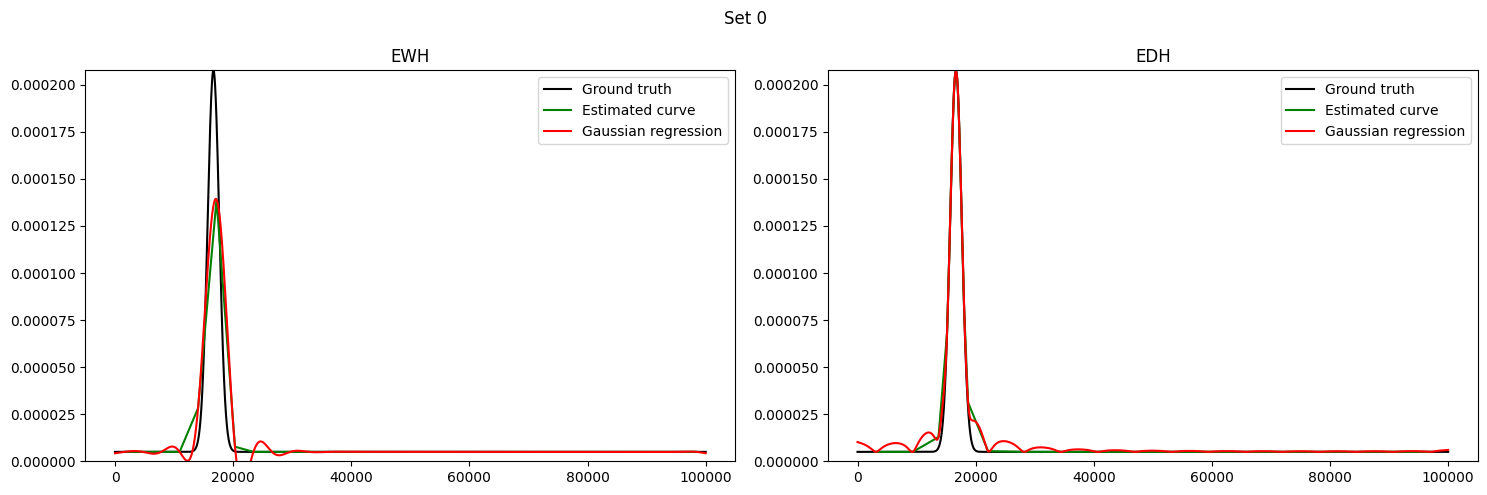

In [9]:
x_test = np.arange(0, len(trs)).reshape(-1, 1)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

ew_bds, ew_trs = convert_ew(bds.copy(), trs.copy())
ew_mod = gaussian_model(ew_bds, ew_trs)
axes[0].set_ylim([0, np.max(trs)])
axes[0].plot(x_test, trs, 'k', label='Ground truth')
axes[0].plot(ew_bds, ew_trs, 'g', label='Estimated curve')
axes[0].plot(x_test, ew_mod.predict(x_test), 'r', label='Gaussian regression')
axes[0].legend()
axes[0].title.set_text('EWH')

ed_bds, ed_trs = convert_ed(bds.copy(), trs.copy())
ed_mod = gaussian_model(ed_bds, ed_trs)
axes[1].set_ylim([0, np.max(trs)])
axes[1].plot(x_test, trs, 'k', label='Ground truth')
axes[1].plot(ed_bds, ed_trs, 'g', label='Estimated curve')
axes[1].plot(x_test, ed_mod.predict(x_test), 'r', label='Gaussian regression')
axes[1].legend()
axes[1].title.set_text('EDH')

fig.suptitle(f'Set {SET_NUM}')
fig.tight_layout()

# LOWESS Regression

Implementation, graphing, and error testing of LOWESS (lowess) regression against the ground-truth transient arrival data. Lowess regression is another non-parametic regression method that involves finding a combination of linear regressions at each datapoint in the training set, with each linear regression using the distance between the current point and it's neighbors in order to determine how each neighbor point affects the weight given in the regression. This experiment makes use of *Moepy's* `Lowess` class for testing purposes

## Implementation:

In [23]:
# lowess model gen
from moepy import lowess

def lowess_model(b_set, t_set):
    lowess_model = lowess.Lowess()
    lowess_model.fit(b_set, t_set, frac=0.11, robust_iters=0)
    return lowess_model

## Graphs:

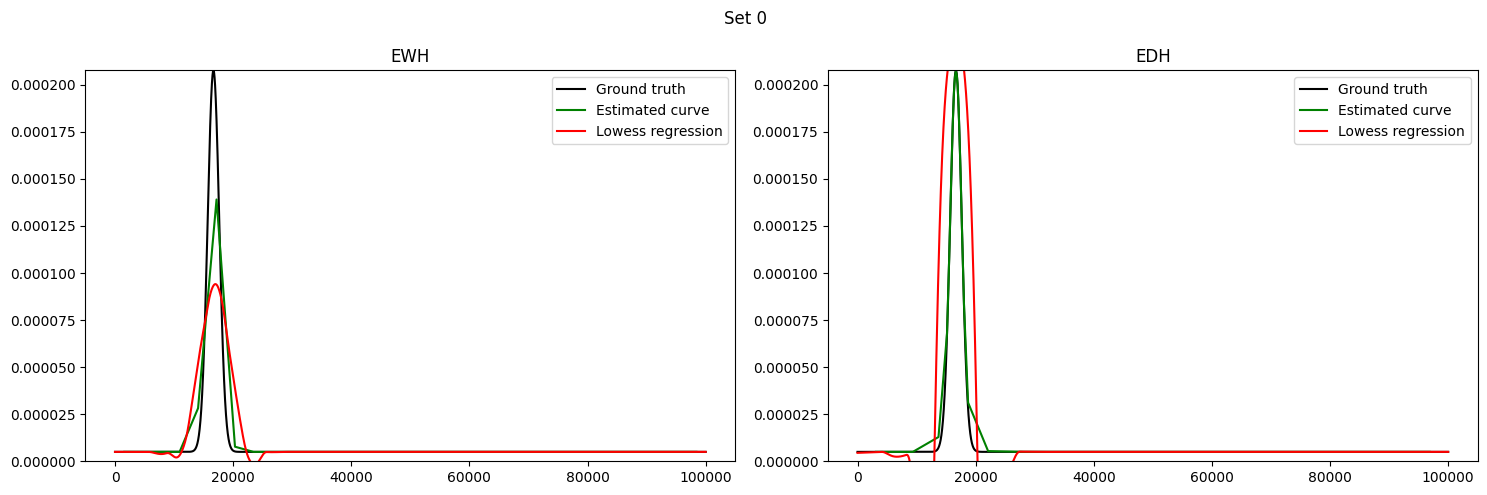

In [24]:
x_test = np.arange(0, len(trs)).reshape(-1, 1)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

ew_bds, ew_trs = convert_ew(bds.copy(), trs.copy())
ew_mod = lowess_model(ew_bds, ew_trs)
axes[0].set_ylim([0, np.max(trs)])
axes[0].plot(x_test, trs, 'k', label='Ground truth')
axes[0].plot(ew_bds, ew_trs, 'g', label='Estimated curve')
axes[0].plot(x_test, ew_mod.predict(x_test), 'r', label='Lowess regression')
axes[0].legend()
axes[0].title.set_text('EWH')

ed_bds, ed_trs = convert_ed(bds.copy(), trs.copy())
ed_mod = lowess_model(ed_bds, ed_trs)
axes[1].set_ylim([0, np.max(trs)])
axes[1].plot(x_test, trs, 'k', label='Ground truth')
axes[1].plot(ed_bds, ed_trs, 'g', label='Estimated curve')
axes[1].plot(x_test, ed_mod.predict(x_test), 'r', label='Lowess regression')
axes[1].legend()
axes[1].title.set_text('EDH')

fig.suptitle(f'Set {SET_NUM}')
fig.tight_layout()

# Kernel Density Estimation (KDE)

Implementation, graphing, and error testing of Kernel Density Estimation (KDE) against the ground-truth transient arrival data. Differing from the other two methods, KDE attempts to find the PMF of the probility of photon arrivals throughout the exposure time. This pmf can then be scaled against the captured transient data in order to reproduce the reponse curve. This experiment makes use of *Scipy's* `gaussian_kde` function for testing purposes

## Implementation:

In [12]:
from scipy.stats import gaussian_kde

def kde_model(b_set, t_set):
    bw = 0.05 # multipled by standard deviation of training set
    return gaussian_kde(b_set, bw_method=bw)

## Graphs:

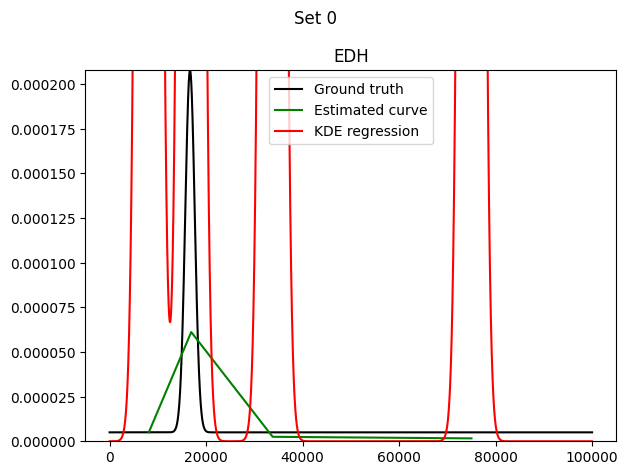

In [13]:
x_test = np.arange(0, len(trs))

fig, axes = plt.subplots()

ed_bds, ed_trs = convert_ed(bds.copy(), trs.copy())
ed_mod = kde_model(ed_bds, ed_trs)
axes.set_ylim([0, np.max(trs)])
axes.plot(x_test, trs, 'k', label='Ground truth')
axes.plot(ed_bds, ed_trs, 'g', label='Estimated curve')
axes.plot(x_test, ed_mod.evaluate(x_test)*len(ed_bds)*10, 'r', label='KDE regression')
axes.legend()
axes.title.set_text('EDH')

fig.suptitle(f'Set {SET_NUM}')
fig.tight_layout()

# Results

## R2 Error / Bin # ratio

In [24]:
# Import helper functions
from src.gen_dataset import gen_dataset
from src.models import gaussian, kde, lowess
import sklearn.metrics as met

In [25]:
# Generate Error Datasets
def r2_per_bin(x_set, max_bins, model):
    r2_scores = []
    for i in range(4, max_bins+1)[::-1]:
        bounds, trans = gen_dataset(i)        
        DEFAULT_TR = stats.mode(stats.mode(data) for data in trans)
        bds, trs = convert_ed(bounds[0, :].copy(), trans[0, :].copy())
        pred_vals = model(bds, trs, x_set)
        r2_scores.append(met.r2_score(trans[0, :].copy(), pred_vals))
    return r2_scores

/Users/csaldanha/src/python/SPAD_Regression_Research/venv/lib/python3.11/site-packages/moepy/lowess.py:38: RuntimeWarning: divide by zero encountered in divide
  dist_to_weights = lambda dist, dist_threshold=1: (1 - ((np.abs(dist)/dist_threshold).clip(0, 1) ** 3)) ** 3
/Users/csaldanha/src/python/SPAD_Regression_Research/venv/lib/python3.11/site-packages/moepy/lowess.py:38: RuntimeWarning: invalid value encountered in divide
  dist_to_weights = lambda dist, dist_threshold=1: (1 - ((np.abs(dist)/dist_threshold).clip(0, 1) ** 3)) ** 3
/Users/csaldanha/src/python/SPAD_Regression_Research/venv/lib/python3.11/site-packages/moepy/lowess.py:38: RuntimeWarning: divide by zero encountered in divide
  dist_to_weights = lambda dist, dist_threshold=1: (1 - ((np.abs(dist)/dist_threshold).clip(0, 1) ** 3)) ** 3
/Users/csaldanha/src/python/SPAD_Regression_Research/venv/lib/python3.11/site-packages/moepy/lowess.py:38: RuntimeWarning: invalid value encountered in divide
  dist_to_weights = lambda dist,

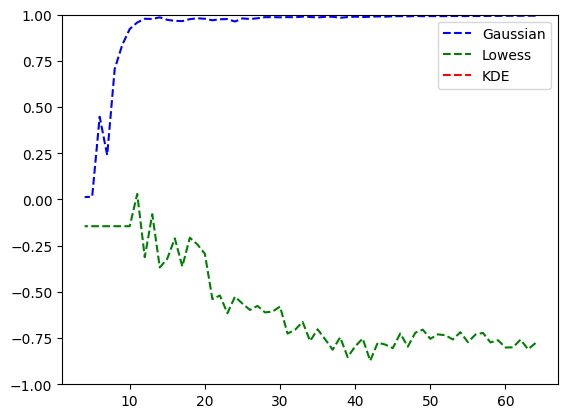

In [29]:
# Graph Results
MAX_BINS = 64

x_test = np.arange(0, LASER_RES)
x_plot = np.arange(4, MAX_BINS+1)[::-1]

ax = plt.gca()
ax.set_ylim([-1, 1])
plt.plot(x_plot, r2_per_bin(x_test.reshape(-1, 1), MAX_BINS, gaussian.regression_fit), 'b', linestyle='--', label='Gaussian')
plt.plot(x_plot, r2_per_bin(x_test.reshape(-1, 1), MAX_BINS, lowess.regression_fit), 'g', linestyle='--', label='Lowess')
plt.plot(x_plot, r2_per_bin(x_test, MAX_BINS, kde.regression_fit), 'r', linestyle='--', label='KDE')
plt.legend()